# data engenering 

In [1]:
# Etape 1 : Extraire les genres secondaires uniques
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Chargement du fichier CSV nettoyé
df = pd.read_csv("book_match_clean.csv", sep=";")

# Nettoyage de la colonne des genres secondaires (retirer les NaN, splitter par ',')
genres_list = df['Genres Secondaires'].dropna().str.split(',')

# Aplatir, nettoyer les genres et enlever les doublons
flattened_genres = set(
    genre.strip()
    for sublist in genres_list
    for genre in sublist
    if genre.strip()
)

# Trier les genres secondaires pour un affichage stable
unique_genres = sorted(flattened_genres)

# Étape 2 : Générer les embeddings des genres avec sentence-transformers
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

# Encodage des genres secondaires uniques en vecteurs
genre_embeddings = {
    genre: model.encode(genre) for genre in unique_genres
}

# Étape 3 : Trouver le genre secondaire le plus représentatif par ligne
reduced_genres = []

for raw in df['Genres Secondaires']:
    if pd.isna(raw):
        reduced_genres.append(None)
        continue

    genres = [g.strip() for g in raw.split(',') if g.strip() in genre_embeddings]
    if not genres:
        reduced_genres.append(None)
        continue

    vectors = [genre_embeddings[g] for g in genres]
    mean_vector = sum(vectors) / len(vectors)
    similarities = {
        g: cosine_similarity([genre_embeddings[g]], [mean_vector])[0][0] for g in genres
    }
    best_match = max(similarities, key=similarities.get)
    reduced_genres.append(best_match)

# Ajouter la colonne au DataFrame
df['Genre_Sec_Privege'] = reduced_genres

# === Étape 4 : Embedding des genres principaux et secondaires ===

# Fonction utilitaire pour encoder un genre (texte) en vecteur
def encode_genre(genre):
    if pd.isna(genre):
        return np.zeros(384)  # vecteur nul si valeur manquante
    return model.encode(genre.strip())

# Encodage du genre principal
df['Embedding_Genre_Principal'] = df['Genre Principal'].apply(encode_genre)

# Encodage du genre secondaire privilégié
df['Embedding_Genre_Secondaire'] = df['Genre_Sec_Privege'].apply(encode_genre)

# Aperçu des vecteurs
print("Vecteur du genre principal (ligne 0) :")
print(df['Embedding_Genre_Principal'].iloc[0])
print("\nVecteur du genre secondaire privilégié (ligne 0) :")
print(df['Embedding_Genre_Secondaire'].iloc[0])


/Users/matthieurubio/Library/Mobile Documents/com~apple~CloudDocs/albert/semestre 3 et 4 /data/semestre 4 /projet_ml_book/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Vecteur du genre principal (ligne 0) :
[ 1.43081741e-02 -8.80362913e-02 -1.13642059e-01 -5.63247614e-02
 -1.71572387e-01  6.20661080e-02 -2.00921878e-01 -2.16192856e-01
  4.73815441e-01  2.53608644e-01  4.19471748e-02  1.00751119e-02
 -2.03426078e-01 -1.05383873e-01  2.05725744e-01 -4.47065264e-01
  2.07234621e-01 -4.44140553e-01  8.19137916e-02  5.89989901e-01
  6.80387795e-01  3.38288933e-01  4.33074564e-01 -2.27531478e-01
  2.92916209e-01 -9.06080976e-02  2.42946073e-01 -2.87909806e-02
 -7.47667134e-01 -5.02832949e-01  2.45556738e-02 -2.42610499e-01
 -4.23364162e-01 -4.84661698e-01  4.04156119e-01  6.65518343e-01
  4.73399252e-01  4.16101485e-01  1.61339477e-01 -2.96460509e-01
 -3.88271618e-03  2.67473254e-02  2.84593374e-01 -1.29352406e-01
 -2.23286435e-01 -6.84115738e-02 -3.39347363e-01  3.32976848e-01
  2.49432921e-01 -3.04698080e-01 -1.20646238e+00  2.65447646e-01
  8.70233774e-03 -2.63354778e-01  2.62217641e-01 -5.31639636e-01
  3.61036845e-02  2.26288185e-01  5.07708788e-02 -3

In [2]:
# Ajout de features utilisateur globales
user_stats = df.groupby('User-ID')['Book-Rating'].agg(
    User_Mean_Rating='mean',
    User_Rating_Count='count',
    User_Rating_Std='std'
).reset_index()

# Fusion avec le df
df = df.merge(user_stats, on='User-ID', how='left')

In [3]:
df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Book-Rating', 'Age', 'AgeGroup', 'Genre Principal',
       'Genres Secondaires', 'Image-URL-L', 'User-ID', 'Genre_Sec_Privege',
       'Embedding_Genre_Principal', 'Embedding_Genre_Secondaire',
       'User_Mean_Rating', 'User_Rating_Count', 'User_Rating_Std'],
      dtype='object')

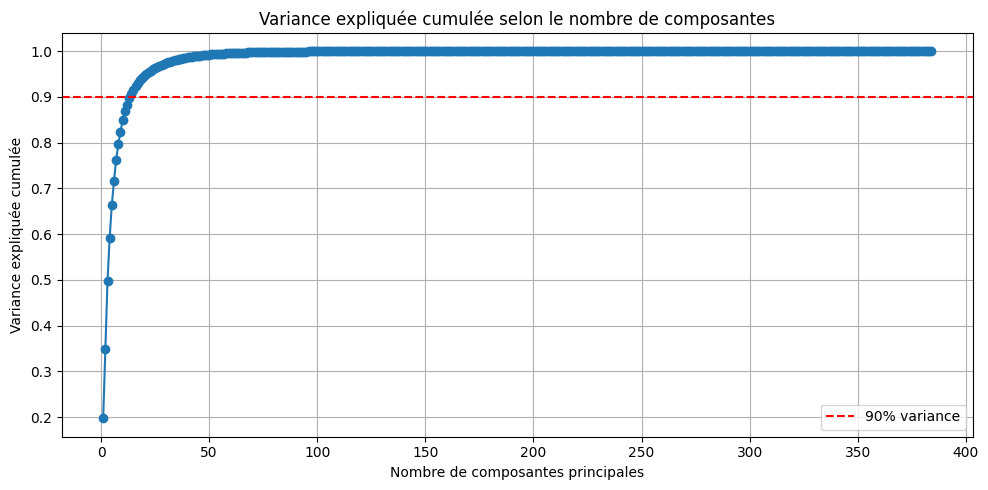

Nombre optimal de composantes pour 90% de variance : 14


In [4]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# === Étape 1 : Combinaison pondérée des embeddings ===
def combine_embeddings(row, alpha=0.7):
    return alpha * row['Embedding_Genre_Principal'] + (1 - alpha) * row['Embedding_Genre_Secondaire']

df['Combined_Embedding'] = df.apply(lambda row: combine_embeddings(row), axis=1)

# === Étape 2 : Construction de la matrice d'embeddings combinés ===
embedding_matrix = np.vstack(df['Combined_Embedding'].values)

# === Étape 3 : PCA sans réduction pour calculer la variance cumulée ===
pca = PCA()
pca.fit(embedding_matrix)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# === Étape 4 : Visualisation ===
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
plt.title('Variance expliquée cumulée selon le nombre de composantes')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Étape 5 : Nombre optimal de composantes pour 90% de variance ===
optimal_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Nombre optimal de composantes pour 90% de variance : {optimal_components}")

# === Étape 6 : Réduction finale avec le bon nombre de composantes ===
pca_final = PCA(n_components=optimal_components, random_state=42)
reduced_embeddings = pca_final.fit_transform(embedding_matrix)

# === Étape 7 : Intégrer dans le DataFrame ===
for i in range(reduced_embeddings.shape[1]):
    df[f'Genre_PC_{i}'] = reduced_embeddings[:, i]

In [5]:
# Calcul de l'ancienneté de publication
current_year = 2025
df['Book_Age'] = current_year - pd.to_datetime(df["Year-Of-Publication"], errors='coerce').dt.year.fillna(current_year).astype(int)

In [6]:
df.Book_Age.nunique()

53

Book age n'est pas important 

# test des modeles avec chosi des features

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Supprimer les utilisateurs avec moins de 5 notes
user_counts = df['User-ID'].value_counts()
valid_users = user_counts[user_counts >= 5].index
df = df[df['User-ID'].isin(valid_users)].copy()

# Encodage de l'ID utilisateur
user_encoder = LabelEncoder()
df['User_ID_Encoded'] = user_encoder.fit_transform(df['User-ID'])

# Colonnes PCA (embeddings réduits)
embedding_cols = [col for col in df.columns if col.startswith('Genre_PC_')]

# Colonnes numériques utilisateur
user_features = ['Age', 'User_ID_Encoded', 'User_Mean_Rating', 'User_Rating_Count', 'User_Rating_Std']

# Encodage AgeGroup (si présente)
if 'AgeGroup' in df.columns:
    agegroup_dummies = pd.get_dummies(df['AgeGroup'], prefix='AgeGroup')
else:
    agegroup_dummies = pd.DataFrame()

# Suppression des lignes avec NaN (au cas où User_Rating_Std reste manquant)
df = df.dropna(subset=user_features)

# Assemblage final
X = pd.concat([df[embedding_cols + user_features], agegroup_dummies], axis=1)
y = df['Book-Rating']

# Découpage train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X

,Genre_PC_0,Genre_PC_1,Genre_PC_2,Genre_PC_3,Genre_PC_4,Genre_PC_5,Genre_PC_6,Genre_PC_7,Genre_PC_8,Genre_PC_9,...,User_ID_Encoded,User_Mean_Rating,User_Rating_Count,User_Rating_Std,AgeGroup_Adolescent 12-17,AgeGroup_Adulte 26-35,AgeGroup_Adulte 36-50,AgeGroup_Enfant 1-12,AgeGroup_Jeune adulte 18-25,AgeGroup_Senior 50+
1,1.226493,-0.940609,1.191445,0.417867,0.238164,-0.187261,0.490354,-0.341572,0.161054,0.255791,...,9,6.500000,6,2.167948,False,False,False,False,True,False
2,1.226493,-0.940609,1.191445,0.417867,0.238164,-0.187261,0.490354,-0.341572,0.161054,0.255791,...,11,7.937500,16,1.181454,False,True,False,False,False,False
3,1.226493,-0.940609,1.191445,0.417867,0.238164,-0.187261,0.490354,-0.341572,0.161054,0.255791,...,27,7.741935,31,0.773207,False,False,True,False,False,False
7,1.226493,-0.940609,1.191445,0.417867,0.238164,-0.187261,0.490354,-0.341572,0.161054,0.255791,...,42,7.542857,35,1.146423,False,True,False,False,False,False
8,1.226493,-0.940609,1.191445,0.417867,0.238164,-0.187261,0.490354,-0.341572,0.161054,0.255791,...,43,7.454545,11,1.035725,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22445,-2.733270,4.384271,-0.010036,3.562384,1.141477,0.944975,-0.046762,-1.084979,0.479202,0.758365,...,890,8.000000,5,0.707107,False,False,False,False,True,False
22449,1.250317,-0.361850,0.109247,-0.162420,0.051429,-0.031808,-0.744241,0.862813,-0.471468,0.395873,...,904,7.600000,5,1.140175,False,False,False,False,False,True
22454,0.701122,3.139007,1.164840,-2.699675,-1.144917,0.435887,0.625496,-0.641799,-0.036006,-0.345561,...,953,8.666667,15,1.632993,False,False,True,False,False,False
22455,-1.824525,0.524623,-1.764639,0.071583,0.865064,-0.779881,-1.334697,0.775301,-1.043996,-0.165109,...,953,8.666667,15,1.632993,False,False,True,False,False,False


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Grille d'hyperparamètres réduite
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

# Initialiser le modèle
rf = RandomForestRegressor(random_state=42)

# Lancer la recherche
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Évaluer le meilleur modèle
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Calcul manuel du RMSE (car squared=False n’est pas supporté)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("MAE :", round(mae, 4))
print("RMSE :", round(rmse, 4))
print("R² :", round(r2, 4))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if p

Meilleurs hyperparamètres : {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
MAE : 0.829
RMSE : 1.1433
R² : 0.2339


In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Grille d’hyperparamètres XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialisation du modèle
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Recherche GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Meilleur modèle
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Évaluation (sans squared=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("MAE :", round(mae, 4))
print("RMSE :", round(rmse, 4))
print("R² :", round(r2, 4))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Meilleurs hyperparamètres : {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
MAE : 0.824
RMSE : 1.1234
R² : 0.2602


In [11]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Grille d'hyperparamètres LightGBM
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10, -1],  # -1 = no limit
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50],
    'subsample': [0.8, 1.0]
}

# Initialiser le modèle
lgbm = LGBMRegressor(random_state=42)

# Recherche
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Meilleur modèle
best_lgbm = grid_search.best_estimator_
y_pred = best_lgbm.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("MAE :", round(mae, 4))
print("RMSE :", round(rmse, 4))
print("R² :", round(r2, 4))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3667
[LightGBM] [Info] Number of data points in the train set: 10615, number of used features: 24
[LightGBM] [Info] Start training from score 7.965615
Meilleurs hyperparamètres : {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}
MAE : 0.8262
RMSE : 1.1339
R² : 0.2464


In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Grille d'hyperparamètres (k voisinage)
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

# Modèle
knn = KNeighborsRegressor()

# GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

# Entraînement
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("MAE :", round(mae, 4))
print("RMSE :", round(rmse, 4))
print("R² :", round(r2, 4))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Meilleurs hyperparamètres : {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
MAE : 0.9356
RMSE : 1.2625
R² : 0.0658


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialiser et entraîner le modèle
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédictions
y_pred = lr.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Résultats Linear Regression")
print("MAE :", round(mae, 4))
print("RMSE :", round(rmse, 4))
print("R² :", round(r2, 4))

Résultats Linear Regression
MAE : 0.8375
RMSE : 1.1311
R² : 0.25


In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# === Préparation des données ===

# Colonnes utilisées
embedding_cols = [col for col in df.columns if col.startswith('Genre_PC_')]
user_features = ['Age', 'User_Mean_Rating', 'User_Rating_Count', 'User_Rating_Std']
X_numeric = df[user_features]
X_genre = df[embedding_cols]
X_user_id = df['User_ID_Encoded'].values.reshape(-1, 1)
y = df['Book-Rating'].values.astype(np.float32)

# Normalisation
scaler_numeric = StandardScaler()
X_numeric_scaled = scaler_numeric.fit_transform(X_numeric)

# Tensors
X_numeric_tensor = torch.tensor(X_numeric_scaled, dtype=torch.float32)
X_genre_tensor = torch.tensor(X_genre.values, dtype=torch.float32)
X_user_tensor = torch.tensor(X_user_id, dtype=torch.long)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Dataset complet
full_dataset = TensorDataset(X_numeric_tensor, X_genre_tensor, X_user_tensor, y_tensor)

# Split train/test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

# === Définition du modèle ===

class MLPBookRegressor(nn.Module):
    def __init__(self, num_users, genre_dim, user_feat_dim):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, 16)
        self.mlp = nn.Sequential(
            nn.Linear(16 + genre_dim + user_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x_numeric, x_genre, x_user):
        user_emb = self.user_embedding(x_user).squeeze(1)
        x = torch.cat([x_numeric, x_genre, user_emb], dim=1)
        return self.mlp(x)

# Initialisation
num_users = df['User_ID_Encoded'].nunique()
model = MLPBookRegressor(num_users=num_users, genre_dim=X_genre.shape[1], user_feat_dim=X_numeric.shape[1])

# Optimiseur et perte
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# === Entraînement ===

for epoch in range(10):
    model.train()
    running_loss = 0
    for xb_num, xb_genre, xb_user, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb_num, xb_genre, xb_user)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss : {running_loss / len(train_loader):.4f}")

# === Évaluation ===

model.eval()
with torch.no_grad():
    y_preds = []
    y_true = []
    for xb_num, xb_genre, xb_user, yb in test_loader:
        preds = model(xb_num, xb_genre, xb_user).squeeze().numpy()
        y_preds.extend(preds)
        y_true.extend(yb.squeeze().numpy())

mae = mean_absolute_error(y_true, y_preds)
rmse = np.sqrt(mean_squared_error(y_true, y_preds))
r2 = r2_score(y_true, y_preds)

print("MAE :", round(mae, 4))
print("RMSE :", round(rmse, 4))
print("R² :", round(r2, 4))

Epoch 1 - Loss : 22.4716
Epoch 2 - Loss : 2.5490
Epoch 3 - Loss : 2.3014
Epoch 4 - Loss : 2.1325
Epoch 5 - Loss : 2.0577
Epoch 6 - Loss : 1.9951
Epoch 7 - Loss : 1.8953
Epoch 8 - Loss : 1.8262
Epoch 9 - Loss : 1.7667
Epoch 10 - Loss : 1.6843
MAE : 0.9221
RMSE : 1.2314
R² : 0.1373


## Comparaison des modèles de prédiction du Book Rating

| Modèle                   | MAE     | RMSE    | R²     |
|--------------------------|---------|---------|--------|
| Random Forest            | 0.8290  | 1.1432  | 0.2339 |
| XGBoost                  | 0.8240  | 1.1234  | 0.2602 |
| LightGBM                 | 0.8262  | 1.1339  | 0.2464 |
| KNN                      | 0.9356  | 1.2625  | 0.0658 |
| Régression Linéaire      | 0.8375  | 1.1311  | 0.2500 |
| Réseau de Neurones (MLP) | 0.9221  | 1.2314  | 0.1373 |

Le tableau ci-dessus présente les performances des différents modèles testés à partir du dataset de recommandations de livres. On observe que les modèles XGBoost et LightGBM obtiennent les meilleurs résultats globaux en termes de MAE, RMSE et R². XGBoost atteint un score R² de 0.2602, indiquant qu'il explique mieux la variance des notes attribuées que les autres modèles.

### Modèle retenu : XGBoost

Nous avons donc retenu XGBoost comme modèle final, car il combine une bonne précision (faible MAE et RMSE) avec une capacité de généralisation correcte (meilleur R²).

**Meilleurs hyperparamètres XGBoost obtenus via GridSearchCV :**

```python
{
  'colsample_bytree': 1.0,
  'learning_rate': 0.05,
  'max_depth': 3,
  'n_estimators': 200,
  'subsample': 0.8
}

In [50]:
def recommander_livres_xgboost_complet_sans_note(age_utilisateur, genre_principal, genre_secondaire, df, pca, model_embedding, model_xgb, top_n=5):
    # Étape 1 : Embedding combiné
    emb_princ = model_embedding.encode(genre_principal)
    emb_sec = model_embedding.encode(genre_secondaire)
    emb_comb = 0.7 * emb_princ + 0.3 * emb_sec

    # Étape 2 : Réduction PCA
    reduced_emb = pca.transform([emb_comb])[0]

    # Étape 3 : Préparation du DataFrame
    book_part = df.copy()
    for i in range(pca.n_components_):
        book_part[f"Genre_PC_{i}"] = reduced_emb[i]
    book_part["Age"] = age_utilisateur

    # AgeGroup encoding
    agegroup_dict = {
        "AgeGroup_Enfant 1-12": (1 <= age_utilisateur <= 12),
        "AgeGroup_Adolescent 12-17": (12 < age_utilisateur <= 17),
        "AgeGroup_Jeune adulte 18-25": (17 < age_utilisateur <= 25),
        "AgeGroup_Adulte 26-35": (25 < age_utilisateur <= 35),
        "AgeGroup_Adulte 36-50": (35 < age_utilisateur <= 50),
        "AgeGroup_Senior 50+": (age_utilisateur > 50)
    }
    for col, val in agegroup_dict.items():
        book_part[col] = val

    # Étape 4 : Prédictions
    model_features = model_xgb.get_booster().feature_names
    book_part["Predicted_Rating"] = model_xgb.predict(book_part[model_features])

    # Étape 5 : Tri, dédoublonnage, suppression de la note
    top_books = (
        book_part
        .sort_values(by="Predicted_Rating", ascending=False)
        .drop_duplicates(subset=["Book-Title"])
        .head(top_n)
        .loc[:, ["Book-Title", "Book-Author", "Image-URL-L"]]  # seules les colonnes souhaitées
    )

    return top_books

In [52]:
model_embedding = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
recommandations = recommander_livres_xgboost_complet_sans_note(
    age_utilisateur=24,
    genre_principal="Fantasy",
    genre_secondaire="Adventure",
    df=df,
    pca=pca_final,
    model_embedding=model_embedding,
    model_xgb=best_xgb
)

display(recommandations)

,Book-Title,Book-Author,Image-URL-L
22259,Essentials of Classic Italian Cooking,Marcella Hazan,http://images.amazon.com/images/P/039458404X.0...
20191,A Wild Sheep Chase,Haruki Murakami,http://images.amazon.com/images/P/037571894X.0...
21476,Interlopers (Ace Science Fiction),Alan Dean Foster,http://images.amazon.com/images/P/044100847X.0...
22386,Berserker: Blue Death,Fred Saberhagen,http://images.amazon.com/images/P/0812553292.0...
21785,Jane's Warlord (Berkley Sensation),Angela Knight,http://images.amazon.com/images/P/0425196844.0...
